In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import GammaRegressor, ElasticNet, LogisticRegression
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_validate, GridSearchCV, train_test_split

from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

# Чтение, анализ и предобработка данных

In [2]:
data = pd.read_csv('flats_moscow1.csv', sep='\s+')
data.head()

,n,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3


In [3]:
data.drop(columns=['n'], inplace=True)
data.head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,81,58,40,6.0,12.5,7,1,1,1,3
1,75,44,28,6.0,13.5,7,1,0,1,6
2,128,70,42,6.0,14.5,3,1,1,1,3
3,95,61,37,6.0,13.5,7,1,0,1,1
4,330,104,60,11.0,10.5,7,0,1,1,3


In [4]:
y = data['price']
X = data.drop(columns=['price'])

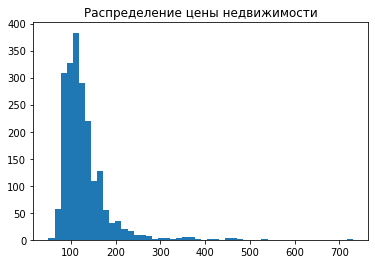

In [5]:
plt.title('Распределение цены недвижимости')
plt.hist(y, bins=50)
plt.savefig('price_distribution.png')
plt.show()

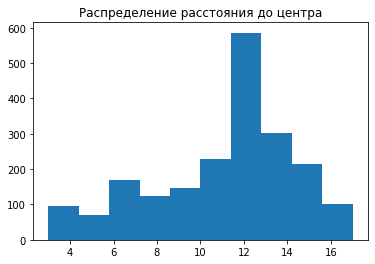

In [6]:
plt.title('Распределение расстояния до центра')
plt.hist(X['dist'], bins=10)
plt.savefig('dist_distribution.png')
plt.show()

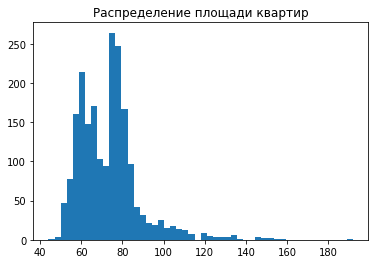

In [7]:
plt.title('Распределение площади квартир')
plt.hist(X['totsp'], bins=50)
plt.savefig('totsp_distribution.png')
plt.show()

In [8]:
scaler = StandardScaler(copy=False)
X[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']] = scaler.fit_transform(X[['totsp', 'livesp', 'kitsp', 'dist', 'metrdist']])

X.head()

,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,-0.997657,-0.802955,-1.040245,0.439834,-0.292860,1,1,1,3
1,-1.923598,-2.323403,-1.040245,0.736156,-0.292860,1,0,1,6
2,-0.203992,-0.549547,-1.040245,1.032478,-1.341452,1,1,1,3
3,-0.799241,-1.183067,-1.040245,0.736156,-0.292860,1,0,1,1
4,2.044723,1.731124,0.754191,-0.152809,-0.292860,0,1,1,3


In [9]:
one_hot = OneHotEncoder(sparse=False)
one_hot_codes = one_hot.fit_transform(np.array(X['code']).reshape(-1, 1))
one_hot_codes = pd.DataFrame(one_hot_codes)
one_hot_codes

,0,1,2,3,4,5,6,7
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2035,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2036,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2037,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2038,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X.drop(columns=['code'], inplace=True)

In [11]:
X_columns_names = X.columns
codes_columns_names = ['code_' + str(one_hot_code) for one_hot_code in one_hot_codes]

X_columns_names = list(X_columns_names) + codes_columns_names
print(X_columns_names)

['totsp', 'livesp', 'kitsp', 'dist', 'metrdist', 'walk', 'brick', 'floor', 'code_0', 'code_1', 'code_2', 'code_3', 'code_4', 'code_5', 'code_6', 'code_7']


In [12]:
d = dict([(i, X_columns_names[i]) for i in range(len(X_columns_names))])
d

{0: 'totsp',
 1: 'livesp',
 2: 'kitsp',
 3: 'dist',
 4: 'metrdist',
 5: 'walk',
 6: 'brick',
 7: 'floor',
 8: 'code_0',
 9: 'code_1',
 10: 'code_2',
 11: 'code_3',
 12: 'code_4',
 13: 'code_5',
 14: 'code_6',
 15: 'code_7'}

In [13]:
X = pd.DataFrame(np.hstack((X, one_hot_codes)))
X.rename(columns=d, inplace=True)

X.head()

,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code_0,code_1,code_2,code_3,code_4,code_5,code_6,code_7
0,-0.997657,-0.802955,-1.040245,0.439834,-0.292860,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-1.923598,-2.323403,-1.040245,0.736156,-0.292860,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.203992,-0.549547,-1.040245,1.032478,-1.341452,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.799241,-1.183067,-1.040245,0.736156,-0.292860,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.044723,1.731124,0.754191,-0.152809,-0.292860,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Обучение и валидация моделей

In [14]:
def full_process(regressor):
    cv = KFold(n_splits=5, shuffle=True, random_state=0)
    metrics = cross_validate(regressor, X, y, cv=cv, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'])
    for k in metrics.keys():
        metrics[k] = metrics[k].mean()
    return metrics

In [15]:
regressors = [
    GradientBoostingRegressor(n_estimators=500, random_state=0), 
    RandomForestRegressor(n_estimators=500, random_state=0), 
    GammaRegressor(max_iter=500),
    ElasticNet(), 
    LogisticRegression(random_state=0), 
    SVR()
]

In [16]:
from pprint import pprint
for r in regressors:
    print(r)
    pprint(full_process(r))
    print()

GradientBoostingRegressor(n_estimators=500, random_state=0)
{'fit_time': 0.6113370418548584,
 'score_time': 0.0050011157989501955,
 'test_neg_mean_absolute_error': -14.778454618228812,
 'test_neg_mean_squared_error': -712.2869740564921,
 'test_r2': 0.7357309304435407}

RandomForestRegressor(n_estimators=500, random_state=0)
{'fit_time': 2.371719980239868,
 'score_time': 0.07141575813293458,
 'test_neg_mean_absolute_error': -14.334900364251762,
 'test_neg_mean_squared_error': -675.5590113513267,
 'test_r2': 0.7471571387501061}

GammaRegressor(max_iter=500)
{'fit_time': 0.006723356246948242,
 'score_time': 0.0020021915435791014,
 'test_neg_mean_absolute_error': -19.21194370948897,
 'test_neg_mean_squared_error': -1021.9080907588966,
 'test_r2': 0.6217859173976588}

ElasticNet()
{'fit_time': 0.0032012462615966797,
 'score_time': 0.002800273895263672,
 'test_neg_mean_absolute_error': -18.36852396246604,
 'test_neg_mean_squared_error': -962.538727696865,
 'test_r2': 0.6445823492917763}

Log

In [17]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'max_depth': [3, 4, 5]
}

gbr = GradientBoostingRegressor(random_state=0)

grid_search = GridSearchCV(estimator=gbr, 
                           param_grid=param_grid, 
                           cv=cv,
                           n_jobs=-1,
                           scoring='r2')

grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=GradientBoostingRegressor(random_state=0), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [500, 1000, 1500],
                         'subsample': [0.7, 0.8, 0.9, 1.0]},
             scoring='r2')

In [18]:
results = pd.DataFrame(grid_search.cv_results_)
results = results[[
    'mean_fit_time',                 
    'param_learning_rate', 
    'param_n_estimators',
    'param_subsample',
    'param_max_depth',
    'mean_test_score',
    'rank_test_score'
]]

In [19]:
results[results['rank_test_score'] == 1]

,mean_fit_time,param_learning_rate,param_n_estimators,param_subsample,param_max_depth,mean_test_score,rank_test_score
90,2.532782,0.01,1000,0.9,4,0.756752,1


Вывод

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [21]:
reg = GradientBoostingRegressor(**grid_search.best_params_)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=1000,
                          subsample=0.9)

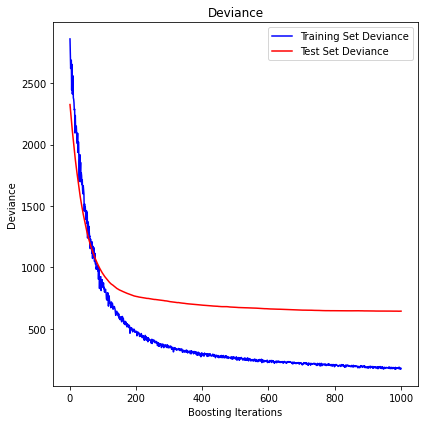

In [22]:
test_score = np.zeros((grid_search.best_params_['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(grid_search.best_params_['n_estimators']) + 1, reg.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(grid_search.best_params_['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')
fig.tight_layout()
plt.savefig('deviance.png')
plt.show()

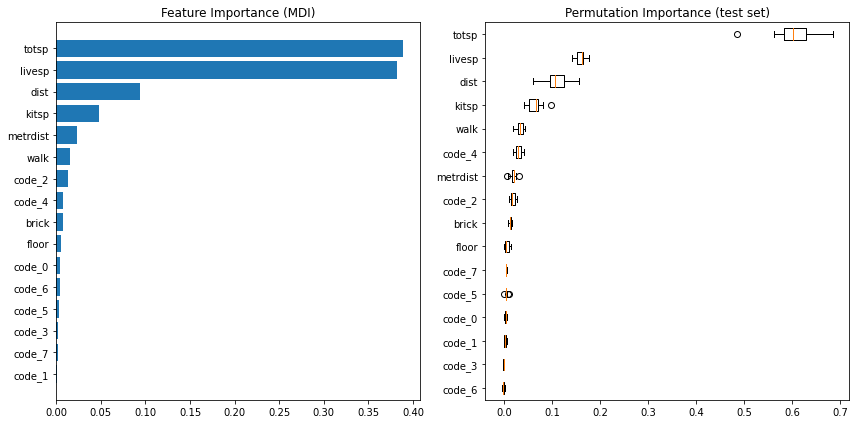

In [23]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(reg, X_test, y_test, n_repeats=10,
                                random_state=0, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(X.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.savefig('fi_pi.png')
plt.show()